<h1>Imports and Helper Functions</h1>

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_congestion_window(cwnds, ax):
    num_users = cwnds.shape[0]
    for i in range(num_users):
        ax.plot(cwnds[i, :], label=f'User {i+1}')
    ax.set_xlabel('RTT')
    ax.set_ylabel('Cwnd')
    ax.set_title('Congestion Window Evolution')
    ax.grid(True)

def plot_throughput(throughputs, ax):
    total_throughput = np.sum(throughputs, axis=0)
    ax.plot(total_throughput[:999])  
    ax.set_xlabel('RTT')
    ax.set_ylabel('Throughput')
    ax.set_title('Throughput over Time')
    ax.grid(True)

def jains_fairness_index(throughputs):
    sum_throughputs = np.sum(throughputs)
    sum_squared_throughputs = np.sum(np.square(throughputs))
    n = len(throughputs)
    return (sum_throughputs ** 2) / (n * sum_squared_throughputs)

def calculate_percentage_throughput(throughputs):
    total_throughput = np.sum(throughputs)
    percentage_throughputs = (throughputs / total_throughput) * 100
    return percentage_throughputs

def calculate_variance_and_stddev(throughputs):
    variance = np.var(throughputs)
    stddev = np.std(throughputs)
    return variance, stddev

def calculate_overall_throughput(throughputs, network_capacity, num_rtt):
    return (np.sum(throughputs[:, :num_rtt]) / (network_capacity * num_rtt)) * 100

def simulate_aimd(num_users, max_rtt, adjust_a, adjust_b, network_capacity=1000):

    if adjust_a == 1:
        alpha = (((network_capacity-20)/network_capacity)**(num_users**2 - (0.08 * network_capacity))) + 1
    else:
        alpha = 1

    beta = 0.5
        
    cwnds = np.full((num_users, max_rtt), 10)  # Set Initial Cwnd to 10 for every sender
    ssthresh = np.full((num_users,), 0.7 * network_capacity / num_users)  # Initial slow start threshold for each sender
    rtt = np.arange(max_rtt)
    exited_slow_start = np.full((num_users,), False)  # Track whether each sender has exited slow start
    throughputs = np.zeros((num_users, max_rtt))  # Initialize throughputs
    
    for t in rtt[:-1]: 
        total_cwnd = np.sum(cwnds[:, t])  # Network Usage at time t
        lost_users = [] # List of senders that will experience packet loss

        # If exceed network capacity,
        # Randomly select users to experience packet loss, with more likely to be chosen if they have a larger congestion window size
        if total_cwnd > network_capacity:  
            exceed_percentage = (total_cwnd - network_capacity) / total_cwnd
            num_lost_users = int(np.ceil(exceed_percentage * num_users ))
            probabilities = cwnds[:, t] / total_cwnd
            lost_users = np.random.choice(num_users, size=num_lost_users, replace=False, p=probabilities)
            for lost_user in lost_users:
                if adjust_b == 1:
                    cwnds[lost_user, t+1] = min(cwnds[lost_user, t] * beta, 0.9 * network_capacity/num_users)  # Multiplicative decrease
                else:
                    cwnds[lost_user, t+1] = cwnds[lost_user, t] * beta

        for i in range(num_users):
            if i not in lost_users:  # If no packet loss for the user
                if cwnds[i, t] < ssthresh[i] and not exited_slow_start[i]:  # In slow start phase
                    cwnds[i, t+1] = min(cwnds[i, t] * 2, ssthresh[i])
                else:  # Additive Increase
                    exited_slow_start[i] = True  # Mark that the sender has exited slow start
                    cwnds[i, t+1] = cwnds[i, t] + alpha
            else:
                cwnds[i, t+1] = max(cwnds[i, t+1], 10)  # Ensure congestion window size is at least 10

        # Calculate throughput
        if total_cwnd <= network_capacity:
            throughputs[:, t] = cwnds[:, t]
        else:
            throughputs[:, t] = cwnds[:, t] * network_capacity / total_cwnd

    return cwnds, throughputs

def print_stats(throughputs, max_rtt):
    # Calculate Jain's fairness index for the first max_rtt RTTs
    fairness_index = jains_fairness_index(np.sum(throughputs, axis=1))
    print('Jain\'s Fairness Index:', fairness_index)

    # Calculate percentage throughput for each user
    percentage_throughputs = calculate_percentage_throughput(np.sum(throughputs, axis=1))
    print('Percentage Throughputs:', percentage_throughputs)

    variance, stddev = calculate_variance_and_stddev(percentage_throughputs)
    print('Variance:', variance)
    print('Standard Deviation:', stddev)
    
    overall_throughput = calculate_overall_throughput(throughputs, 1000, max_rtt)
    print('Overall Throughput:', overall_throughput, "%")

<h1>Simulate AIMD for TCP Reno with alpha = 1 and beta = 0.5</h1>

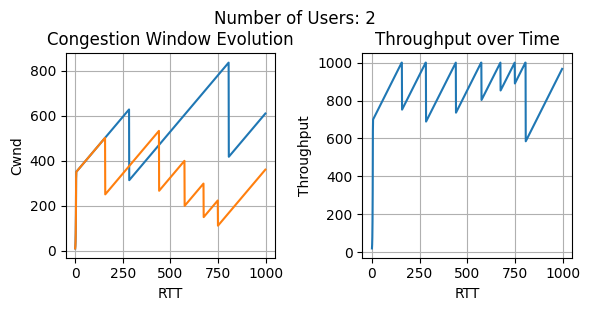

Jain's Fairness Index: 0.9390898243006096
Percentage Throughputs: [62.73389789 37.26610211]
Variance: 162.15215553196293
Standard Deviation: 12.733897892317298
Overall Throughput: 85.28529999999999 %


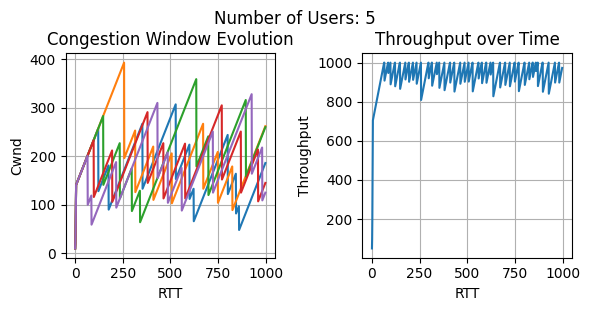

Jain's Fairness Index: 0.9963284808994618
Percentage Throughputs: [18.21433812 21.16167873 21.48672361 19.92183239 19.21542714]
Variance: 1.4740195310782123
Standard Deviation: 1.2140920603801888
Overall Throughput: 93.2442 %


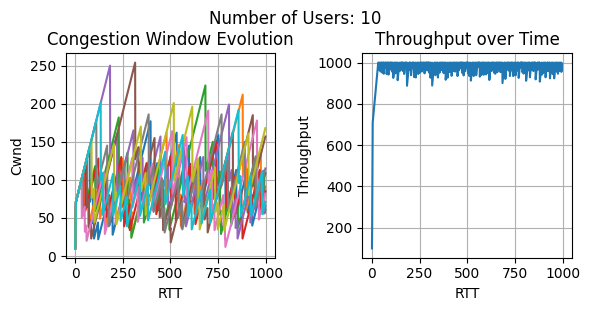

Jain's Fairness Index: 0.9929412727290172
Percentage Throughputs: [ 9.50785866  9.48451589  9.69915331  8.64432157 11.52760917 10.75649425
  9.30995866 10.39006184 11.01351561  9.66651104]
Variance: 0.71089071074492
Standard Deviation: 0.8431433512427884
Overall Throughput: 96.9536 %


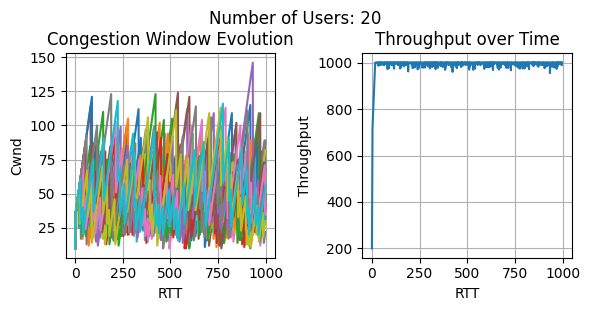

Jain's Fairness Index: 0.992601691934265
Percentage Throughputs: [5.54520727 4.87634178 4.49116441 4.34645641 5.21181633 5.81416037
 4.49463783 4.36228424 4.52298785 4.53200242 5.14013569 4.92399783
 5.03440267 4.69874797 5.15908754 5.19633901 5.46963952 5.55142454
 5.25122525 5.37794108]
Variance: 0.18633627480822273
Standard Deviation: 0.43166685627717905
Overall Throughput: 99.1989 %


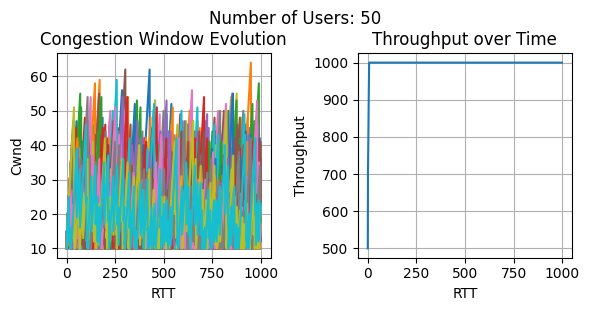

Jain's Fairness Index: 0.997388931034735
Percentage Throughputs: [2.08861112 2.35798957 1.86037426 1.97929016 1.90129389 2.05153995
 2.03338562 2.02455222 2.0380301  1.89137005 2.12309067 1.88439348
 2.06829532 2.04918621 2.0352013  2.10244234 2.15373137 1.99965358
 2.00224779 1.99995378 1.96634877 1.85603846 1.94051573 1.98510934
 2.01075781 2.11221482 1.90157073 2.00961405 1.89524451 2.044656
 2.12588428 2.01600941 2.06271765 2.08457079 2.03697976 1.87252804
 1.82699232 1.95441573 1.9492624  1.9418797  2.06869666 1.92643793
 1.69039558 2.05441819 2.06266845 1.96372255 2.04534239 2.05809642
 1.94122053 1.95105824]
Variance: 0.010471617977777284
Standard Deviation: 0.10233092385871088
Overall Throughput: 99.74499999999999 %


In [2]:
num_users_list = [2, 5, 10, 20, 50]
max_rtt = 1000
adjust_a = 0
adjust_b = 0

for num_users in num_users_list:
    cwnds, throughputs = simulate_aimd(num_users, max_rtt, adjust_a, adjust_b)

    # Create a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Plot the congestion window size and throughput on the subplots
    plot_congestion_window(cwnds, axs[0])
    plot_throughput(throughputs, axs[1])

    plt.tight_layout()
    plt.suptitle(f'Number of Users: {num_users}', y=1.02)
    plt.show()

    print_stats(throughputs, max_rtt)


<h1>Simulate AIMD with new alpha only</h1>

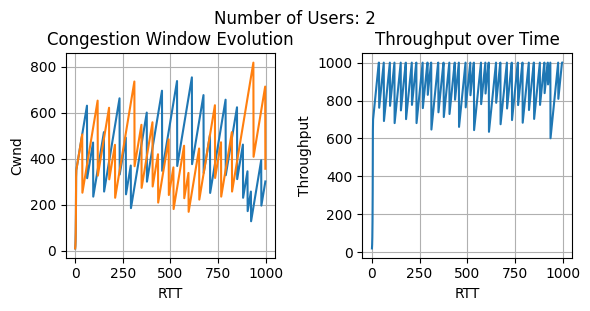

Jain's Fairness Index: 0.9998596370285837
Percentage Throughputs: [50.59241598 49.40758402]
Variance: 0.3509566898642776
Standard Deviation: 0.5924159770501447
Overall Throughput: 85.9816 %


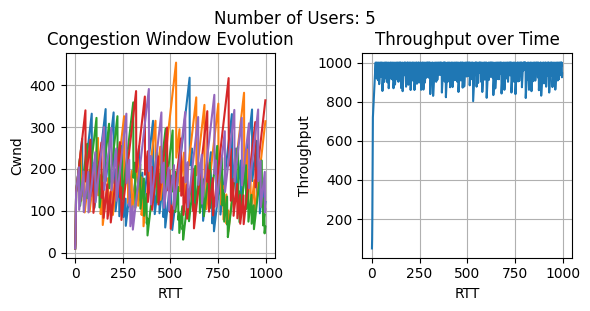

Jain's Fairness Index: 0.9943746738696508
Percentage Throughputs: [19.29842426 20.96765413 17.51715378 20.31334281 21.90342502]
Variance: 2.2628597763689804
Standard Deviation: 1.504280484606837
Overall Throughput: 94.78410000000001 %


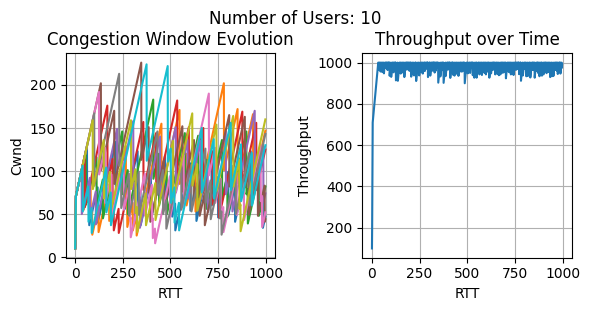

Jain's Fairness Index: 0.9904821505085689
Percentage Throughputs: [ 8.00416567 10.24189178  9.69170682 10.9568909   9.92936191 11.58661487
  8.92352765  9.66849692 10.13234692 10.86499656]
Variance: 0.960930945251681
Standard Deviation: 0.9802708530052707
Overall Throughput: 96.9468 %


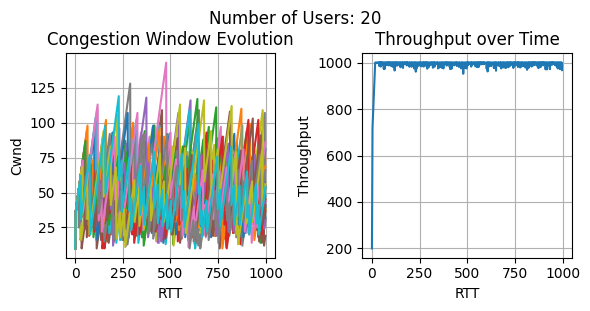

Jain's Fairness Index: 0.9930877258593411
Percentage Throughputs: [4.8975306  4.84243536 5.369545   4.27688541 5.53811214 4.08795915
 5.22685818 5.12291162 5.0114484  5.01048991 5.05189207 5.23135533
 5.46343682 4.61816336 4.71943494 4.873197   5.63381953 4.38208506
 5.53998324 5.10245689]
Variance: 0.17400965596160156
Standard Deviation: 0.4171446463297852
Overall Throughput: 99.18149999999999 %


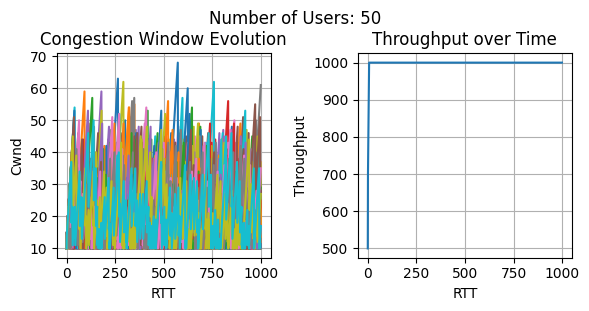

Jain's Fairness Index: 0.9978503225495396
Percentage Throughputs: [2.14857565 1.94240713 2.04504414 1.99289419 2.03335575 2.04621863
 1.99475815 1.9317574  1.93231282 2.06731561 1.98400067 2.01488255
 2.01009513 1.80822911 2.12923907 2.06626011 1.95711721 1.98933599
 2.14013287 1.95675177 2.16909093 2.04069359 1.95253352 1.89619475
 1.96461939 2.19801578 1.82826781 1.90136244 2.10929808 2.03075519
 2.13516458 1.99471218 2.00937391 1.90079988 1.87742394 1.95428039
 2.06189781 1.93963545 2.13281994 1.82959116 1.88635965 2.01536382
 1.89767703 1.82796897 2.0733618  2.05328104 2.02029928 2.07035678
 1.99110378 2.04701316]
Variance: 0.008617234075617625
Standard Deviation: 0.09282905835791735
Overall Throughput: 99.74500000000002 %


In [13]:
num_users_list = [2,5,10,20,50]
max_rtt = 1000
adjust_a = 1
adjust_b = 0

for num_users in num_users_list:
    cwnds, throughputs = simulate_aimd(num_users, max_rtt, adjust_a, adjust_b)

    # Create a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Plot the congestion window size and throughput on the subplots
    plot_congestion_window(cwnds, axs[0])
    plot_throughput(throughputs, axs[1])

    plt.tight_layout()
    plt.suptitle(f'Number of Users: {num_users}', y=1.02)
    plt.show()

    print_stats(throughputs, max_rtt)

<h1>Simulate AIMD with new beta only</h1>

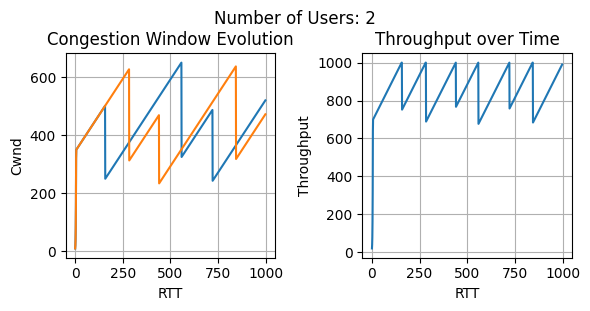

Jain's Fairness Index: 0.9995999840546895
Percentage Throughputs: [48.99978 51.00022]
Variance: 1.0004400552503974
Standard Deviation: 1.0002200034244453
Overall Throughput: 85.1977 %


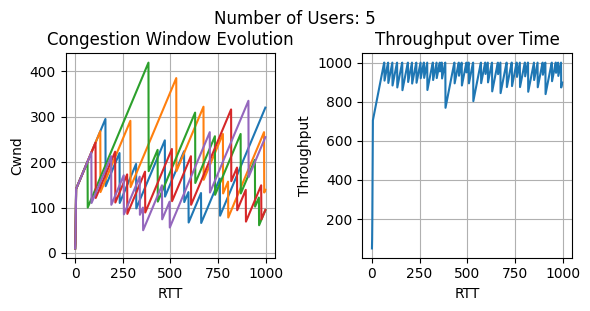

Jain's Fairness Index: 0.9848376193895261
Percentage Throughputs: [18.56849328 23.43808852 22.54867946 17.56267899 17.88205976]
Variance: 6.158327144274813
Standard Deviation: 2.4815976999253553
Overall Throughput: 93.2449 %


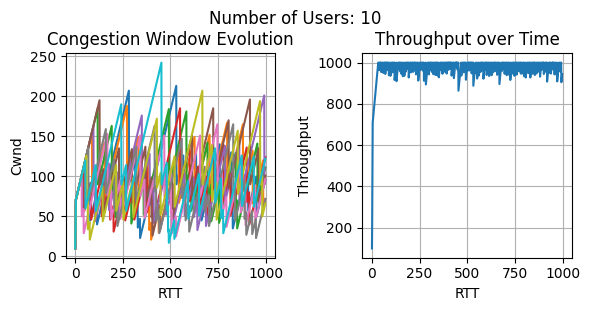

Jain's Fairness Index: 0.9938818089169853
Percentage Throughputs: [10.05797773 10.95159596 10.41078833  8.92347736  9.88547887 11.19539215
  8.94693093  8.94188091 10.42397185 10.26250591]
Variance: 0.6155853772675223
Standard Deviation: 0.7845924912128093
Overall Throughput: 96.8091 %


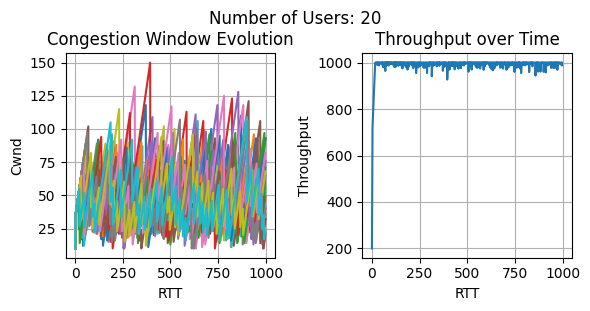

Jain's Fairness Index: 0.9953556096000327
Percentage Throughputs: [5.48582407 5.02821907 4.76478988 5.2154295  5.49582083 4.80834067
 5.05819318 4.14768579 5.33575522 4.80611945 4.90091114 5.10874461
 4.68103729 5.26309888 5.27193036 5.06119177 5.51104865 4.68619237
 4.64509375 4.72457353]
Variance: 0.11665153526972982
Standard Deviation: 0.3415428747166742
Overall Throughput: 99.1481 %


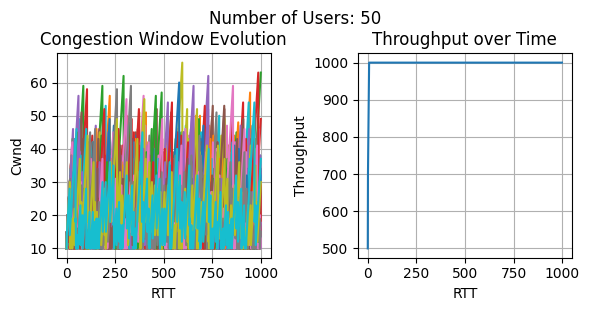

Jain's Fairness Index: 0.9975800063816107
Percentage Throughputs: [2.04400614 1.94270361 2.13578122 2.07244661 2.11794561 2.03068717
 1.95827661 1.7723054  1.92404189 2.0749469  1.97360717 2.00004711
 2.09242014 2.07542955 2.01334123 1.95399124 2.08362933 1.88334526
 2.013698   1.99204548 1.85952043 2.1525964  2.0382461  2.06199083
 1.99206209 1.85306629 1.90585073 2.15678774 1.9906034  1.8451242
 1.85090013 1.89855502 2.09195031 2.08637556 2.11018469 1.92472613
 2.16942344 1.82828341 2.04799965 2.04192054 2.06095462 1.82780254
 1.88435104 2.14580557 1.98882622 2.02055476 2.03040679 2.03750385
 2.04169159 1.9012403 ]
Variance: 0.009703456777033522
Standard Deviation: 0.09850612558127297
Overall Throughput: 99.74499999999999 %


In [20]:
num_users_list = [2,5,10,20,50]
max_rtt = 1000
adjust_a = 0
adjust_b = 1

for num_users in num_users_list:
    cwnds, throughputs = simulate_aimd(num_users, max_rtt, adjust_a, adjust_b)

    # Create a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Plot the congestion window size and throughput on the subplots
    plot_congestion_window(cwnds, axs[0])
    plot_throughput(throughputs, axs[1])

    plt.tight_layout()
    plt.suptitle(f'Number of Users: {num_users}', y=1.02)
    plt.show()

    print_stats(throughputs, max_rtt)

<h1>Simulate AIMD with new alpha and beta</h1>

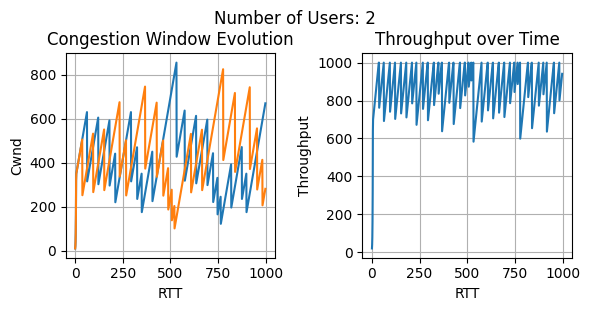

Jain's Fairness Index: 0.9986851869152543
Percentage Throughputs: [48.18578936 51.81421064]
Variance: 3.291360235368633
Standard Deviation: 1.8142106369902677
Overall Throughput: 85.8652 %


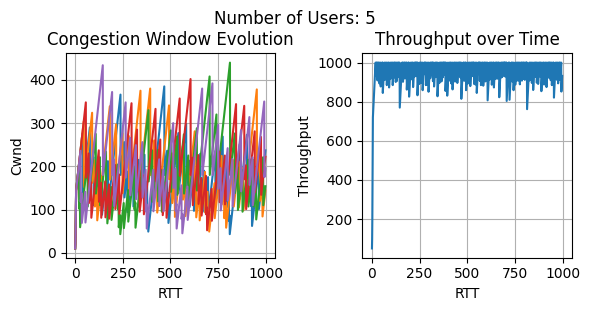

Jain's Fairness Index: 0.9981369555184342
Percentage Throughputs: [18.70952458 20.17288422 19.55763761 20.22077382 21.33917977]
Variance: 0.7466087579528076
Standard Deviation: 0.8640652509809705
Overall Throughput: 94.525 %


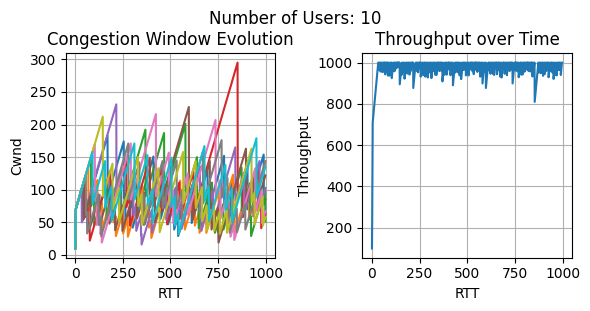

Jain's Fairness Index: 0.99069624716218
Percentage Throughputs: [ 9.99850606  7.67316329 10.61894952 11.35602148  9.69132001  9.39664181
 10.85725892  9.77011532  9.92884506 10.70917853]
Variance: 0.939112554879492
Standard Deviation: 0.9690781985368838
Overall Throughput: 96.7771 %


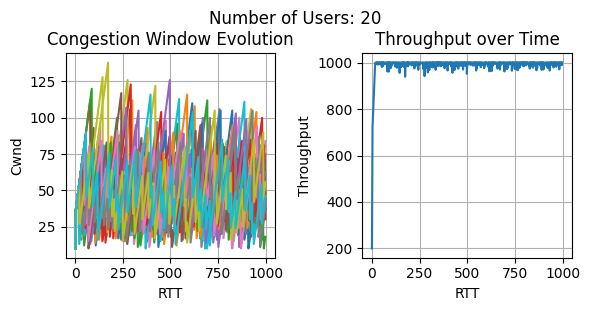

Jain's Fairness Index: 0.9951429766060533
Percentage Throughputs: [4.35993336 5.49885544 5.12786217 5.08997803 5.08125665 4.88046026
 4.99917845 4.67484376 5.62586947 4.47531675 5.28337479 4.98885097
 4.46108933 5.25723621 5.52626147 4.57207597 5.01915013 4.81973592
 5.14246922 5.11620163]
Variance: 0.12201823024746392
Standard Deviation: 0.34931107947997286
Overall Throughput: 99.1303 %


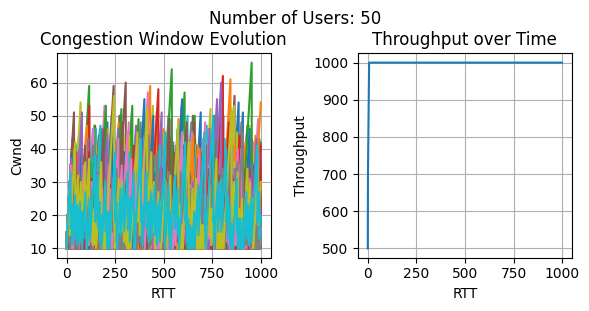

Jain's Fairness Index: 0.9984003857117394
Percentage Throughputs: [2.01352607 1.83001671 2.08255782 1.8195265  1.97497159 1.99503613
 2.03130963 2.02495621 2.00599638 2.0287803  2.06911109 1.93241041
 1.81480197 1.95350556 2.06993794 1.98936509 2.07186438 1.97580998
 2.02955696 1.84089843 1.93212219 2.10243924 2.00667556 1.95465005
 1.96355066 2.03139736 1.96432321 1.924232   2.03820892 1.96686235
 1.96449416 2.06690663 2.13449846 1.91783476 2.10835891 1.9362639
 2.10759564 1.98728024 2.02567281 2.16482398 2.01781278 1.92913663
 2.06104103 2.00284554 2.09513298 2.05534577 1.98251956 1.88368533
 2.12654235 1.99380783]
Variance: 0.0064087086149124724
Standard Deviation: 0.08005441034017097
Overall Throughput: 99.74499999999999 %


In [23]:
num_users_list = [2,5,10,20,50]
max_rtt = 1000
adjust_a = 1
adjust_b = 1

for num_users in num_users_list:
    cwnds, throughputs = simulate_aimd(num_users, max_rtt, adjust_a, adjust_b)

    # Create a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Plot the congestion window size and throughput on the subplots
    plot_congestion_window(cwnds, axs[0])
    plot_throughput(throughputs, axs[1])

    plt.tight_layout()
    plt.suptitle(f'Number of Users: {num_users}', y=1.02)
    plt.show()

    print_stats(throughputs, max_rtt)